Preprocesamiento Dataset Comentarios estudiantes Universidad de Barcelona

In [ ]:
#!python -m spacy download es_core_news_sm
#!pip install unicode
!pip install fasttext

%matplotlib inline
from matplotlib import pyplot as plt
import csv
import warnings
import lxml.html.clean
warnings.filterwarnings('ignore')
import re
from re import sub
import multiprocessing
from textblob import TextBlob
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk import FreqDist
from bs4 import BeautifulSoup
import re, string, unicodedata
import spacy
from sklearn.metrics import accuracy_score

from nltk.tokenize.toktok import ToktokTokenizer
import collections

from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image

from nltk.stem.snowball import SnowballStemmer

nltk.download('punkt')

nltk.download('stopwords') 
stop_words =stopwords.words('spanish')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2) Importar los datos csv en en un dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


#train_data=pd.read_csv('/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/coursera_dataset.csv', delimiter='|', encoding='utf-8',engine='python',header=None,names=header_list,error_bad_lines=False )
train_data=pd.read_csv('/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/UB_students_reviews.csv', encoding='utf-8',engine='python',error_bad_lines=False)

Mounted at /content/gdrive/


3) Análisis preeliminar de los datos

In [ ]:
train_data.head(5)

,reviews,polarity
0,Es muy dura calificando.,NEGATIVE
1,Creo que debería esmerarse un poco más a la hora de corregir los exámenes test ya que no encuentro lógico que entregue las notas la segunda semana de septiembre cuando el examen se realizó en septiembre.,NEGATIVE
2,Desmuestra una falta deorganización y seriedad equiparable a su gestión de la asignatura y el campus virtual el cual no está actualizado conteniendo datos de notas de alumnos del año anterior.,NEGATIVE
3,Una de las cosas que me han gustado han sido las practicas.,NEGATIVE
4,Están muy claras y se entiende claramente lo que se pide.,NEGATIVE


In [ ]:
train_data.tail(5)

,reviews,polarity
1185,El profesor transmite valores políticos (sobretodo económicos) los cuales no tienen por qué ser correctos ni iguales para todos.,NEGATIVE
1186,"Cuando se responden preguntas tipo test descarta posibles respuestas correctas por ideología, puesto que alguienpartidario del capitalismo considera correcta una opción mientras alguien comunista puede dar por buena otra, pero a la hora de corregir se considera correcta la opción capitalista.",NEGATIVE
1187,"Estaría bien también que actualizara, por lo menos, el año delas prácticas cuando nos da los enunciados.",NEGATIVE
1188,Toda la teoría facilitada debería revisarse PROFESSOR_NAME que los exámenes con faltas de ortografía y los tests del Campus Virtual con todas las posibles respuestas erróneas.,NEGATIVE
1189,Nada que destacar.,NEUTRAL


In [ ]:
#Revisar los tipos de datos
train_data.dtypes

reviews     object
polarity    object
dtype: object

In [ ]:
#Análisis de datos
# Número total de filas y columnas
print(f"*****El dataset contiene:{train_data.shape[0]} filas y {train_data.shape[1]} columnas *****")
#Filas que tienen datos duplicados
duplicate_rows_td = train_data[train_data.duplicated()]
print("*****Filas duplicadas", duplicate_rows_td.shape[0])
#Número de filas antes de eliminar duplicados
print(f"*****Número de filas antes de eliminar duplicados ***** \n{train_data.count()}", "\n")
#Eliminar duplicados
train_data = train_data.drop_duplicates()
#Número de filas antes de eliminar duplicados
print(f"*****Número de filas después de eliminar duplicados ***** \n{train_data.count()}", "\n")
print(f"*****Datos nulos en alguna columna ***** \n{train_data.isnull().sum()}", "\n")
#Eliminar Nulos
train_data = train_data.dropna() 
print(f"*****Luego de eliminar nulos ***** \n{train_data.count()}", "\n")
#Filtrar solo aquellos que tienen texto >5 caracteres
train_data = train_data[(train_data['reviews'].apply(len) >10)]

*****El dataset contiene:1190 filas y 2 columnas *****
*****Filas duplicadas 14
*****Número de filas antes de eliminar duplicados ***** 
reviews     1190
polarity    1190
dtype: int64 

*****Número de filas después de eliminar duplicados ***** 
reviews     1176
polarity    1176
dtype: int64 

*****Datos nulos en alguna columna ***** 
reviews     0
polarity    0
dtype: int64 

*****Luego de eliminar nulos ***** 
reviews     1176
polarity    1176
dtype: int64 



In [ ]:
train_data.head()

,reviews,polarity
0,Es muy dura calificando.,NEGATIVE
1,Creo que debería esmerarse un poco más a la hora de corregir los exámenes test ya que no encuentro lógico que entregue las notas la segunda semana de septiembre cuando el examen se realizó en septiembre.,NEGATIVE
2,Desmuestra una falta deorganización y seriedad equiparable a su gestión de la asignatura y el campus virtual el cual no está actualizado conteniendo datos de notas de alumnos del año anterior.,NEGATIVE
3,Una de las cosas que me han gustado han sido las practicas.,NEGATIVE
4,Están muy claras y se entiende claramente lo que se pide.,NEGATIVE


3) Funciones para limpiar texto

In [ ]:
#Funciones para limpiar el texto
#!pip install spacy
#!python -m spacy download es_core_news_sm
stemmer = SnowballStemmer("spanish")
import fasttext
path_to_pretrained_model = '/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/lid.176.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)
stop_words.extend(['si', 'tambien', 'asi', 'debe', 'tener','cada','ademas','parte','ser','ma','mismo','mas'])  

#Funcion para remover tags html
def html_remover(data):
  beauti = BeautifulSoup(data,'html.parser')
  return beauti.get_text()

#Funcion para Remover URLs
def url_remover(data):
  return re.sub(r'https\S','',data)

def clean_text(text):
  #Convertir a minúsculas
  text = text.lower()
  #LLamar funciones para remover html y urls
  text= html_remover(text)
  text = url_remover(text) 
  #Eliminar texto entre corchetes, signos de puntuacion y numeros
  text = re.sub('\[.*?¿\]\%', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub('[‘’“”…«»]', '', text)
  text = re.sub('\n','', text)
  

  #Eliminar tildes y diacriticas
  text = re.sub('á', 'a', text)
  text = re.sub('é', 'e', text)
  text = re.sub('í', 'i', text)
  text = re.sub('ó', 'o', text)
  text = re.sub('ú', 'u', text)
  text = re.sub('ü', 'u', text)
  text = re.sub('ñ', 'n', text)
  text = re.sub('¿', '', text)

  return text

def tokenize_text(text):
  text = word_tokenize(text) 
  text = [word for word in text if word not in stop_words]
  return text

def lang_detect(text):
  languages = ["spanish","english","dutch","german","italian","portuguese","turkish","danish","french"]
  lang_count = {}
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [t.strip().lower() for t in tokens]
  for lang in languages:
    stop_words_l = str(nltk.corpus.stopwords.words(lang))
    lang_count[lang] = 0
    for word in tokens:
      if word in stop_words_l:
        lang_count[lang] += 1
  detected_language = max(lang_count, key=lang_count.get)
  return detected_language

def lang_detect_2(text):
  nlp = spacy.load('en')  # 1
  nlp.add_pipe(LanguageDetector(), name='language_detector', last=True) #2
  doc = nlp(text) #3
  detect_language = doc._.language #4
  return(detect_language)

def lang_detect_3(text):
  lang=fmodel.predict(text)  # ([['__label__en']], [array([0.9331119], dtype=float32)]
  return lang[0][0].replace('__label__', '')

4) Ejecutar limpieza de texto y detección de idioma

In [ ]:
#Ejecutar limpieza de datos
train_data['cleaned'] = train_data['reviews'].apply(clean_text)

In [ ]:
#Explorar los datos una vez ejecutadas las funciones de limpieza
train_data.sample(10)

,reviews,polarity,cleaned
1143,La participación en la clase.,NEUTRAL,la participacion en la clase
976,En una palabra: todo.,NEUTRAL,en una palabra todo
1056,"Las preguntas obligatorias sobran, se hace 3 veces lo mismo, me parece correctas ponerlas en apenas un parcial.",NEGATIVE,las preguntas obligatorias sobran se hace veces lo mismo me parece correctas ponerlas en apenas un parcial
674,"Esta asignatura debería de ser optativa, no veo que nos aporte algo en especial estudiando ingeniería informática.",NEGATIVE,esta asignatura deberia de ser optativa no veo que nos aporte algo en especial estudiando ingenieria informatica
969,"Intentar contestar con un poco más de suavidad o de una mejor forma, ya que a veces responde con cierto tono despectivo o irónico.",NEGATIVE,intentar contestar con un poco mas de suavidad o de una mejor forma ya que a veces responde con cierto tono despectivo o ironico
137,"Se hacomportado muy mal con algunos alumnos, delante de toda la clase (de los que aun asistían a sus clases, vaya) y no tenemos ningún tipo de defensa.",NEGATIVE,se hacomportado muy mal con algunos alumnos delante de toda la clase de los que aun asistian a sus clases vaya y no tenemos ningun tipo de defensa
450,No se hacía nada en clase.,NEGATIVE,no se hacia nada en clase
123,Aporta buenos ejemplos para entender la teoría de la asignatura,NEGATIVE,aporta buenos ejemplos para entender la teoria de la asignatura
878,El tiempo del test (10 minutos) también parece escaso para poder contestar todas las preguntas pensando bien la respuesta.,NEGATIVE,el tiempo del test minutos tambien parece escaso para poder contestar todas las preguntas pensando bien la respuesta
81,Explica bien y repite las cosas si no se entienden.,NEGATIVE,explica bien y repite las cosas si no se entienden


In [ ]:
#Detectar idioma
train_data['lang'] = train_data['cleaned'].apply(lang_detect_3)

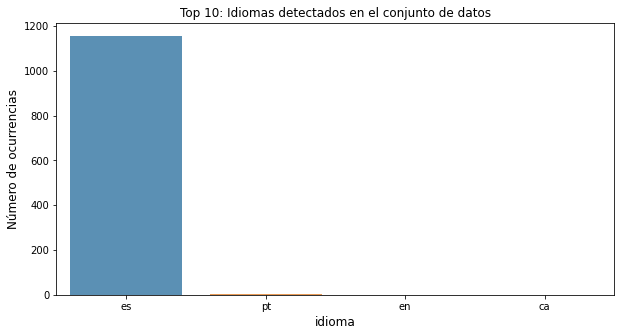

In [ ]:
#Agrupar datos por idioma

lang_count  = train_data["lang"].value_counts()
lang_count = lang_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(lang_count.index, lang_count.values, alpha=0.8)
plt.title('Top 10: Idiomas detectados en el conjunto de datos')
plt.ylabel('Número de ocurrencias', fontsize=12)
plt.xlabel('idioma', fontsize=12)
plt.show()

In [ ]:
train_data = train_data[(train_data['lang'] == 'es')]
print(f"*****Cantidad de registros luego de filtrar el idioma ***** \n{train_data.count()}", "\n")

*****Cantidad de registros luego de filtrar el idioma ***** 
reviews     1155
polarity    1155
cleaned     1155
lang        1155
dtype: int64 



6) Realizar segundo análisis sobre el texto en español

*****Nube de Palabras ***** 
 



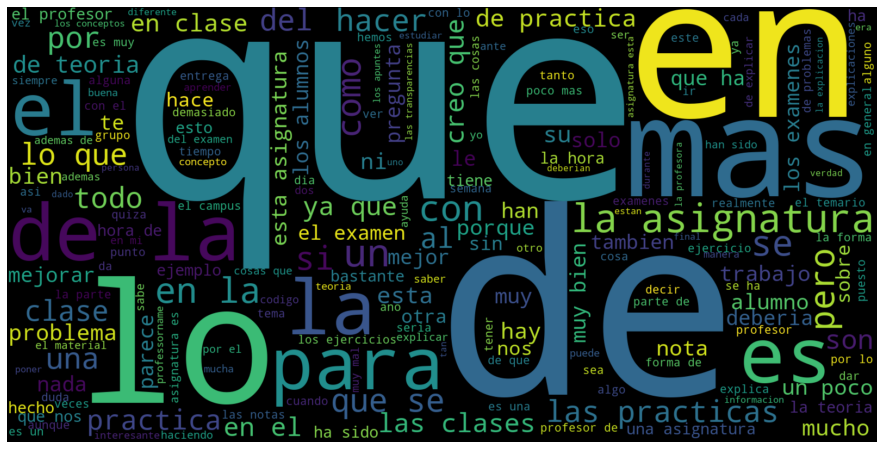

*****2000 palabras mas frecuentes ***** 
[('de', 1156), ('que', 1114), ('la', 729), ('en', 629), ('y', 560), ('el', 522), ('no', 517), ('las', 421), ('a', 365), ('los', 362), ('se', 353), ('es', 286), ('asignatura', 261), ('mas', 244), ('un', 234), ('muy', 215), ('para', 214), ('lo', 199), ('con', 189), ('practicas', 188), ('me', 177), ('ha', 174), ('una', 164), ('por', 163), ('como', 134), ('bien', 134), ('del', 133), ('esta', 129), ('clase', 123), ('pero', 120), ('clases', 113), ('si', 110), ('teoria', 107), ('hacer', 103), ('al', 101), ('ya', 100), ('profesor', 97), ('o', 95), ('son', 89), ('nos', 85), ('examen', 75), ('creo', 73), ('han', 72), ('poco', 71), ('ejercicios', 68), ('parte', 66), ('examenes', 63), ('todo', 63), ('sido', 60), ('nada', 60), ('forma', 59), ('alumnos', 57), ('cosas', 56), ('trabajo', 56), ('tiempo', 55), ('mucho', 55), ('problemas', 55), ('ni', 54), ('mi', 52), ('hay', 52), ('deberia', 48), ('practica', 47), ('hace', 47), ('porque', 47), ('le', 43), ('tambi

In [ ]:
#Unir el dataset limpio una sola cadena para realizar análisis
dataset = [x for x in train_data['cleaned']]
dataset = ' '.join(dataset)

#Imprimir nube de palabras
print(f"*****Nube de Palabras ***** \n", "\n")
wordcloud = WordCloud(
    background_color='black',
    width=1600, height=800).generate(dataset)
plt.figure( figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

tokenizer = ToktokTokenizer()
dataset_tokens = tokenizer.tokenize(dataset)

freq_splits = FreqDist(dataset_tokens)
print(f"*****2000 palabras mas frecuentes ***** \n{freq_splits.most_common(1000)}", "\n")

word_counts = collections.Counter(dataset_tokens)
print(print(f"***** Contador de Palabras ***** \n{word_counts}", "\n"))

*****Nube de Palabras ***** 
 



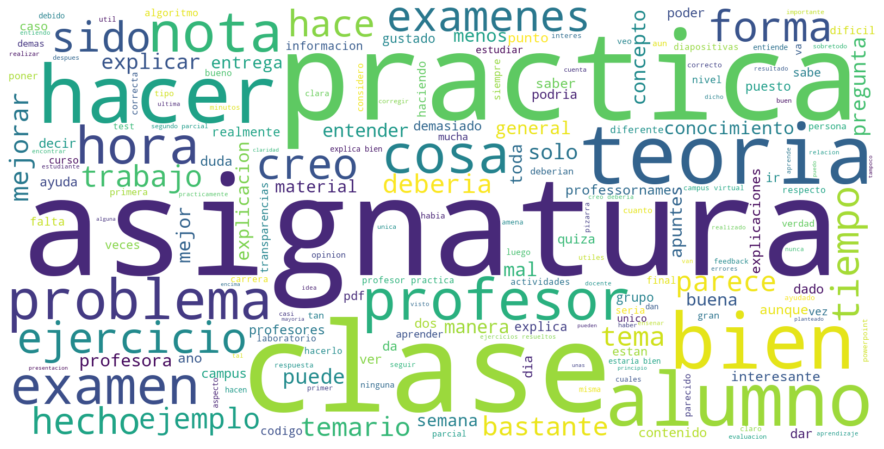

In [ ]:
#Dividir en palabras y eliminar palabras vacias
train_data['tokenized'] = train_data['cleaned'].apply(tokenize_text)

#Imprimir nube de palabras sin stop words
def to_doc(words:tuple) -> spacy.tokens.Doc:
    return ' '.join(words)

train_data['tokens_string'] = train_data['tokenized'].apply(to_doc)

dataset_stw = [x for x in train_data['tokens_string']]
dataset_stw = ' '.join(dataset_stw)

#Imprimir nube de palabras
print(f"*****Nube de Palabras ***** \n", "\n")
wordcloud = WordCloud(
    background_color='white',
    width=1600, height=800).generate(dataset_stw)
plt.figure( figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
train_data.head()

,reviews,polarity,cleaned,lang,tokenized,tokens_string
0,Es muy dura calificando.,NEGATIVE,es muy dura calificando,es,"[dura, calificando]",dura calificando
1,Creo que debería esmerarse un poco más a la hora de corregir los exámenes test ya que no encuentro lógico que entregue las notas la segunda semana de septiembre cuando el examen se realizó en septiembre.,NEGATIVE,creo que deberia esmerarse un poco mas a la hora de corregir los examenes test ya que no encuentro logico que entregue las notas la segunda semana de septiembre cuando el examen se realizo en septiembre,es,"[creo, deberia, esmerarse, hora, corregir, examenes, test, encuentro, logico, entregue, notas, segunda, semana, septiembre, examen, realizo, septiembre]",creo deberia esmerarse hora corregir examenes test encuentro logico entregue notas segunda semana septiembre examen realizo septiembre
2,Desmuestra una falta deorganización y seriedad equiparable a su gestión de la asignatura y el campus virtual el cual no está actualizado conteniendo datos de notas de alumnos del año anterior.,NEGATIVE,desmuestra una falta deorganizacion y seriedad equiparable a su gestion de la asignatura y el campus virtual el cual no esta actualizado conteniendo datos de notas de alumnos del ano anterior,es,"[desmuestra, falta, deorganizacion, seriedad, equiparable, gestion, asignatura, campus, virtual, actualizado, conteniendo, datos, notas, alumnos, ano, anterior]",desmuestra falta deorganizacion seriedad equiparable gestion asignatura campus virtual actualizado conteniendo datos notas alumnos ano anterior
3,Una de las cosas que me han gustado han sido las practicas.,NEGATIVE,una de las cosas que me han gustado han sido las practicas,es,"[cosas, gustado, sido, practicas]",cosas gustado sido practicas
4,Están muy claras y se entiende claramente lo que se pide.,NEGATIVE,estan muy claras y se entiende claramente lo que se pide,es,"[estan, claras, entiende, claramente, pide]",estan claras entiende claramente pide


In [ ]:
print(train_data["polarity"].value_counts())

NEGATIVE    870
POSITIVE    167
NEUTRAL     118
Name: polarity, dtype: int64


In [ ]:
#1 y 2 se asigna polaridad NEGATIVA. Los comentarios con calificación 4 y 5 se asigna polaridad POSITIVA y para calificación 3 polaridad NEUTRAL
def sentiment_label(polarity):
  if(polarity =='POSITIVE'):
    sentiment='POSITIVO'
  if(polarity =='NEGATIVE'):
    sentiment='NEGATIVO'
  if(polarity =='NEUTRAL'):
    sentiment='NEUTRAL'
  return sentiment

def source_data(row):
  return 'STREVIEWS'

train_data['sentiment'] = train_data['polarity'].apply(sentiment_label)
train_data['source'] = train_data.apply(source_data,axis=1)

NEGATIVO    870
POSITIVO    167
NEUTRAL     118
Name: sentiment, dtype: int64


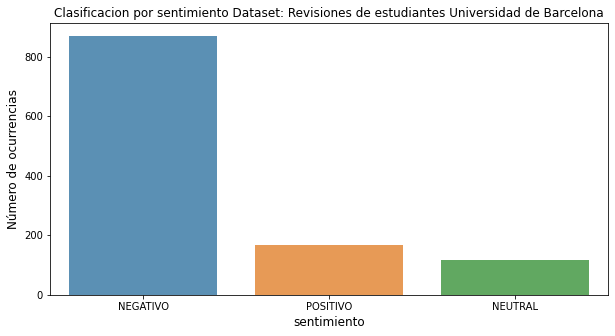

In [ ]:
#Analizar el dataset
#print(train_data["rating"].value_counts())
print(train_data["sentiment"].value_counts())
lang_count  = train_data["sentiment"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(lang_count.index, lang_count.values, alpha=0.8)
plt.title('Clasificacion por sentimiento Dataset: Revisiones de estudiantes Universidad de Barcelona')
plt.ylabel('Número de ocurrencias', fontsize=12)
plt.xlabel('sentimiento', fontsize=12)
plt.show()

In [ ]:
train_data.to_csv('dataset_3_reviews.csv',columns=['cleaned','sentiment','source'])